# Projet d'apprentissage profond pour les images - Quang-Duy Nguyen, Morgan Ramadani
## 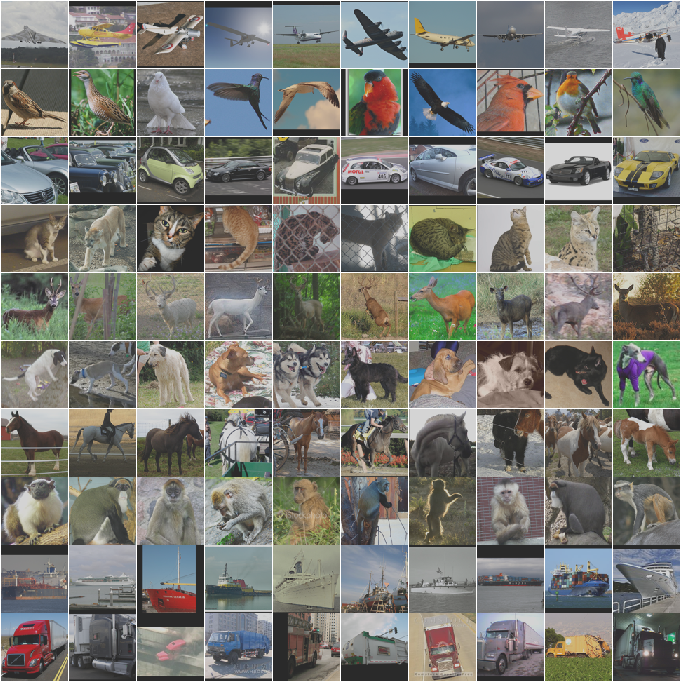

## Installation & Imports

sys.version_info(major=3, minor=9, micro=7, releaselevel='final', serial=0)


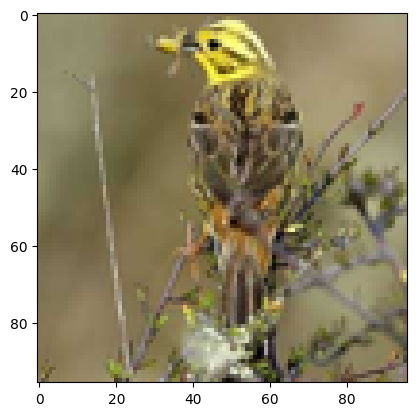

(5000, 96, 96, 3)
(5000,)


In [1]:
from __future__ import print_function

import sys
import os, sys, tarfile, errno
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.preprocessing.image import save_img

if sys.version_info >= (3, 0, 0):
    import urllib.request as urllib # ugly but works
else:
    import urllib

try:
    from imageio import imsave
except:
    from keras.preprocessing.image import save_img
    # from scipy.misc import imsave

print(sys.version_info)

# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_DIR = './data'

# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

# path to the binary train file with image data
DATA_PATH = './data/stl10_binary/train_X.bin'

# path to the binary train file with labels
LABEL_PATH = './data/stl10_binary/train_y.bin'

def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels


def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images


def read_single_image(image_file):
    """
    CAREFUL! - this method uses a file as input instead of the path - so the
    position of the reader will be remembered outside of context of this method.
    :param image_file: the open file containing the images
    :return: a single image
    """
    # read a single image, count determines the number of uint8's to read
    image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)
    # force into image matrix
    image = np.reshape(image, (3, 96, 96))
    # transpose to standard format
    # You might want to comment this line or reverse the shuffle
    # if you will use a learning algorithm like CNN, since they like
    # their channels separated.
    image = np.transpose(image, (2, 1, 0))
    return image


def plot_image(image):
    """
    :param image: the image to be plotted in a 3-D matrix format
    :return: None
    """
    plt.imshow(image)
    plt.show()

def save_image(image, name):
    save_img("%s.png" % name, image, format="png")

def download_and_extract():
    """
    Download and extract the STL-10 dataset
    :return: None
    """
    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)

def save_images(images, labels):
    print("Saving images to disk")
    i = 0
    for image in images:
        label = labels[i]
        directory = './img/' + str(label) + '/'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as exc:
            if exc.errno == errno.EEXIST:
                pass
        filename = directory + str(i)
        print(filename)
        save_image(image, filename)
        i = i+1

if __name__ == "__main__" :
    # download data if needed
    # download_and_extract()

    # test to check if the image is read correctly
    with open(DATA_PATH) as f:
        image = read_single_image(f)
        plot_image(image)

    # test to check if the whole dataset is read correctly
    images = read_all_images(DATA_PATH)
    print(images.shape)

    labels = read_labels(LABEL_PATH)
    print(labels.shape)

    # save images to disk
    # save_images(images, labels)

In [2]:
images = read_all_images(DATA_PATH)

labels = read_labels(LABEL_PATH)

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import cv2

## Data Exploration

In [4]:
# Vérifier qu'il y a pas de déséquilibre de classes
print(np.array(np.unique(labels, return_counts=True)).T)

[[  1 500]
 [  2 500]
 [  3 500]
 [  4 500]
 [  5 500]
 [  6 500]
 [  7 500]
 [  8 500]
 [  9 500]
 [ 10 500]]


In [5]:
print(images.shape)
for i in images :
    if i.shape != (96, 96, 3):
        print('dimension problem')

(5000, 96, 96, 3)


## Splitting Data

In [6]:
# Division des données en ensembles d'entraînement et de test (80% pour l'entraînement, 20% pour le test)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Division de l'ensemble d'entraînement en ensembles d'entraînement et de validation (80% pour l'entraînement, 20% pour la validation)
train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Convertir les étiquettes en codage à chaud (one-hot encoding)
num_classes = 10
train_labels = tf.keras.utils.to_categorical(train_labels-1, num_classes)
valid_labels = tf.keras.utils.to_categorical(valid_labels-1, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels-1, num_classes)


# Vérification des dimensions des ensembles
print("Training set:", train_images.shape, train_labels.shape)
print("Validation set:", valid_images.shape, valid_labels.shape)
print("Test set:", test_images.shape, test_labels.shape)


Training set: (3200, 96, 96, 3) (3200, 10)
Validation set: (800, 96, 96, 3) (800, 10)
Test set: (1000, 96, 96, 3) (1000, 10)


## Baseline

### Baseline w/o Attention

In [7]:
input_shape = (96, 96, 3)

inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='linear')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 32)        4640  

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(
                    train_images, train_labels,
                    epochs=2,
                    validation_data=(valid_images, valid_labels),
                    batch_size = 128,
)


Epoch 1/2
25/25 [==============================] - 14s 510ms/step - loss: 18.9377 - accuracy: 0.1084 - val_loss: 2.2742 - val_accuracy: 0.1850
Epoch 2/2
25/25 [==============================] - 13s 501ms/step - loss: 2.1337 - accuracy: 0.2225 - val_loss: 1.9960 - val_accuracy: 0.2663


In [9]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

32/32 [==============================] - 1s 33ms/step - loss: 2.0578 - accuracy: 0.2460
Test Loss: 2.0577502250671387
Test Accuracy: 0.2460000067949295


### Baseline w Attention

In [80]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(SelfAttention, self).__init__()

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.query = layers.Dense(self.channels)
        self.key = layers.Dense(self.channels)
        self.value = layers.Dense(self.channels)
        self.gamma = self.add_weight("gamma", shape=[1], initializer="zeros", trainable=True)

    def call(self, x):
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        attention_weights = tf.nn.softmax(tf.matmul(query, key, transpose_b=True))
        attention_output = tf.matmul(attention_weights, value)
        scaled_attention = self.gamma * attention_output + x
        return scaled_attention

In [81]:
input_shape = (96, 96, 3)

inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='linear')(x)
x = SelfAttention()(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_baseline_attention = models.Model(inputs=inputs, outputs=outputs)
model_baseline_attention.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_49 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 47, 47, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 45, 45, 16)        4624      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 22, 22, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 20, 20, 32)        4640

In [30]:
model_baseline_attention.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model_baseline_attention.fit(
                    train_images, train_labels,
                    epochs=10,
                    validation_data=(valid_images, valid_labels),
                    batch_size = 128,
)


Epoch 1/3
25/25 [==============================] - 18s 630ms/step - loss: 16.6354 - accuracy: 0.1444 - val_loss: 2.7800 - val_accuracy: 0.1725
Epoch 2/3
25/25 [==============================] - 16s 622ms/step - loss: 2.2726 - accuracy: 0.2169 - val_loss: 2.1224 - val_accuracy: 0.2463
Epoch 3/3
25/25 [==============================] - 16s 651ms/step - loss: 1.9884 - accuracy: 0.2828 - val_loss: 1.9595 - val_accuracy: 0.3000


In [46]:
test_loss, test_accuracy = model_baseline_attention.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

32/32 [==============================] - 0s 3ms/step - loss: 2.1000 - accuracy: 0.2160
Test Loss: 2.0999855995178223
Test Accuracy: 0.2160000056028366


## Data Augmentation

### Horizontal Flip

In [31]:
flipped_img = np.empty_like(train_images)

for i in range(train_images.shape[0]):
    flipped_img[i] = np.fliplr(train_images[i])

In [32]:
train_images = np.append(train_images,flipped_img,axis=0)
train_labels = np.append(train_labels,train_labels,axis=0)

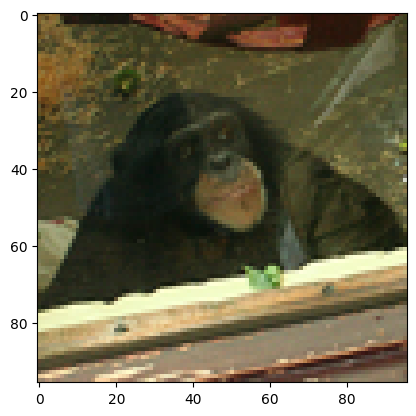

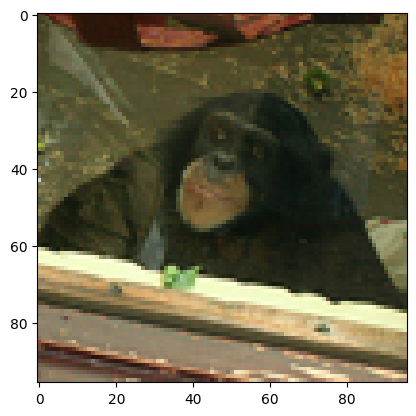

In [8]:
i = random.randint(0,5400)
# i = 0
plot_image(train_images[i])
if i - 3200 >= 0:
    plot_image(train_images[i-3200])
else :
    plot_image(train_images[i+3200])

In [33]:
print(train_images.shape)
print(train_labels.shape)

(6400, 96, 96, 3)
(6400, 10)


### Translation, Shearing, Zooming: Zoom in or out on the image.

In [34]:
# Preprocessing function to add random noise
def add_random_noise(x):
    noise = np.random.normal(0, 0.1, x.shape)  # Generate random noise
    noisy_image = x + noise  # Add noise to the image
    return noisy_image

# Preprocessing function to adjust contrast
def adjust_contrast(x):
    return x
    # contrast_factor = np.random.uniform(0.8, 1.2)  # Adjust contrast by random factor
    # adjusted_image = (x - np.mean(x)) * contrast_factor + np.mean(x)
    # return adjusted_image

def gaussian_blur(x):
    if random.random() <= 0.5 :
        return cv2.GaussianBlur(x, (5, 5), 0)
    else :
        return x

In [35]:
step2 = ImageDataGenerator(
    width_shift_range=0.15,  # Random horizontal shift by 20% of image width
    height_shift_range=0.15,  # Random vertical shift by 20% of image height
    zoom_range=0.2,  # Random zoom in/out by 20%
    shear_range=0.2,
    brightness_range=[0.9, 1.1],  # Random brightness adjustment between 0.5 and 1.5
    preprocessing_function=lambda x: gaussian_blur(adjust_contrast(add_random_noise(x))),  # Gaussian blur with kernel size of (5, 5)
    fill_mode= 'reflect'
)

In [36]:
augmented_generator = step2.flow(train_images.reshape((-1, 96, 96, 3)), train_labels, batch_size=1)

# Generate augmented images and corresponding labels
augmented_images = []
augmented_labels = []
num_augmented_images = 0

for _ in range(6400):
    batch = augmented_generator.next()
    augmented_images.append(batch[0][0].astype(np.uint8))
    augmented_labels.append(batch[1])
    num_augmented_images += 1

# Convert the augmented images and labels back to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# # Reshape the augmented images back to the original shape
# augmented_images = augmented_images.reshape((-1, 96, 96, 3))

# Verify the shape of the augmented images and labels
print(augmented_images.shape)  # (6400, 96, 96, 3)
print(augmented_labels.shape)  # (6400, num_classes)

    

(6400, 96, 96, 3)
(6400, 1, 10)


In [37]:
augmented_labels = augmented_labels.reshape(6400,10)

In [38]:
augmented_labels[4]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

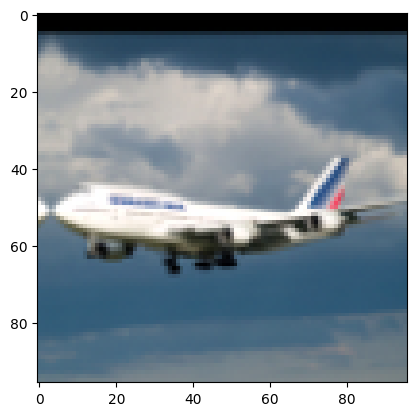

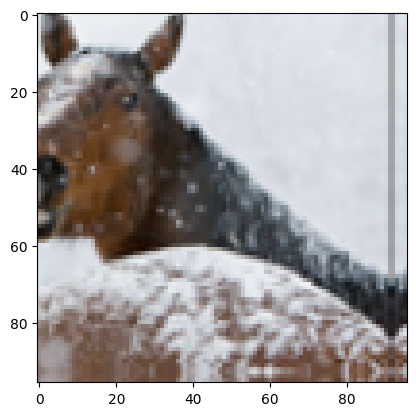

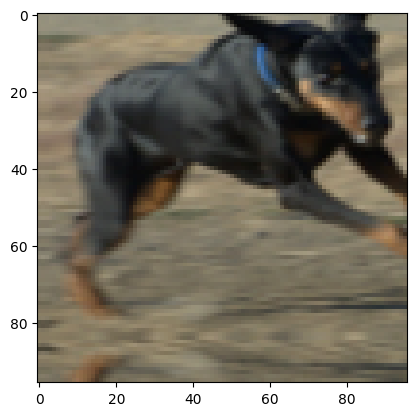

In [39]:
count = 0
for image in augmented_images :
    if count > 2:
        break
    plot_image(image)
    count+=1

In [40]:
# Charger une nouvelle image à prédire
image_path = 'chemin/vers/la/nouvelle/image.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(96, 96))
image = tf.keras.preprocessing.image.img_to_array(image)
image = image / 255.0  # Normalisation

# Prédiction de l'image
prediction = model.predict(tf.expand_dims(image, axis=0))
predicted_class = tf.argmax(prediction, axis=1)


FileNotFoundError: [Errno 2] No such file or directory: 'chemin/vers/la/nouvelle/image.jpg'

## Modèles pré entrainés

### Les modèles pré entrainés 

In [34]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from transformers import CLIPProcessor, TFCLIPModel

model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# model = hub.load("https://tfhub.dev/openai/clip/1")

# # Charger vos images et étiquettes dans deux tableaux distincts
# images = ...  # Vos images prétraitées (tableau numpy)
# labels = ...  # Vos étiquettes correspondantes (tableau numpy)

# Convertir les tableaux en tenseurs TensorFlow
images_tensor = tf.convert_to_tensor(images)
labels_tensor = tf.convert_to_tensor(labels)

# Obtenir les embeddings des images
image_embeddings = model.predict(images_tensor)

# Obtenir les embeddings des étiquettes
label_embeddings = model.encode_text(labels_tensor)

# Calculer les similarités entre les embeddings d'image et d'étiquette
similarities = tf.matmul(image_embeddings, label_embeddings, transpose_b=True)

# Obtenir les indices des classes prédites pour chaque image
predicted_classes = tf.argmax(similarities, axis=1)


All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


ValueError: in user code:

    File "c:\Users\ramad\Documents\Deep_Learning_Images\ComputerVisionIASD\.venv\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\ramad\Documents\Deep_Learning_Images\ComputerVisionIASD\.venv\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ramad\Documents\Deep_Learning_Images\ComputerVisionIASD\.venv\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\ramad\Documents\Deep_Learning_Images\ComputerVisionIASD\.venv\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "c:\Users\ramad\Documents\Deep_Learning_Images\ComputerVisionIASD\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\ramad\AppData\Local\Temp\__autograph_generated_filek1r14e_g.py", line 37, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "C:\Users\ramad\AppData\Local\Temp\__autograph_generated_filetwqqbnic.py", line 36, in tf__call
        outputs = ag__.converted_call(ag__.ld(self).clip, (), dict(input_ids=ag__.ld(input_ids), pixel_values=ag__.ld(pixel_values), attention_mask=ag__.ld(attention_mask), position_ids=ag__.ld(position_ids), return_loss=ag__.ld(return_loss), output_attentions=ag__.ld(output_attentions), output_hidden_states=ag__.ld(output_hidden_states), return_dict=ag__.ld(return_dict)), fscope)
    File "C:\Users\ramad\AppData\Local\Temp\__autograph_generated_filek1r14e_g.py", line 37, in tf__run_call_with_unpacked_inputs
        retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
    File "C:\Users\ramad\AppData\Local\Temp\__autograph_generated_file6xg6fy_o.py", line 36, in tf__call
        ag__.if_stmt(ag__.ld(pixel_values) is None, if_body_1, else_body_1, get_state_1, set_state_1, (), 0)
    File "C:\Users\ramad\AppData\Local\Temp\__autograph_generated_file6xg6fy_o.py", line 32, in if_body_1
        raise ag__.converted_call(ag__.ld(ValueError), ('You have to specify pixel_values',), None, fscope)

    ValueError: Exception encountered when calling layer 'tfclip_model_3' (type TFCLIPModel).
    
    in user code:
    
        File "c:\Users\ramad\Documents\Deep_Learning_Images\ComputerVisionIASD\.venv\lib\site-packages\transformers\modeling_tf_utils.py", line 1255, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "c:\Users\ramad\Documents\Deep_Learning_Images\ComputerVisionIASD\.venv\lib\site-packages\transformers\models\clip\modeling_tf_clip.py", line 1279, in call  *
            outputs = self.clip(
        File "c:\Users\ramad\Documents\Deep_Learning_Images\ComputerVisionIASD\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "C:\Users\ramad\AppData\Local\Temp\__autograph_generated_filek1r14e_g.py", line 37, in tf__run_call_with_unpacked_inputs
            retval_ = ag__.converted_call(ag__.ld(func), (ag__.ld(self),), dict(**ag__.ld(unpacked_inputs)), fscope)
        File "C:\Users\ramad\AppData\Local\Temp\__autograph_generated_file6xg6fy_o.py", line 36, in tf__call
            ag__.if_stmt(ag__.ld(pixel_values) is None, if_body_1, else_body_1, get_state_1, set_state_1, (), 0)
        File "C:\Users\ramad\AppData\Local\Temp\__autograph_generated_file6xg6fy_o.py", line 32, in if_body_1
            raise ag__.converted_call(ag__.ld(ValueError), ('You have to specify pixel_values',), None, fscope)
    
        ValueError: Exception encountered when calling layer 'clip' (type TFCLIPMainLayer).
        
        in user code:
        
            File "c:\Users\ramad\Documents\Deep_Learning_Images\ComputerVisionIASD\.venv\lib\site-packages\transformers\modeling_tf_utils.py", line 1255, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "c:\Users\ramad\Documents\Deep_Learning_Images\ComputerVisionIASD\.venv\lib\site-packages\transformers\models\clip\modeling_tf_clip.py", line 827, in call  *
                raise ValueError("You have to specify pixel_values")
        
            ValueError: You have to specify pixel_values
        
        
        Call arguments received by layer 'clip' (type TFCLIPMainLayer):
          • input_ids=tf.Tensor(shape=(None, 96, 96, 3), dtype=uint8)
          • pixel_values=None
          • attention_mask=None
          • position_ids=None
          • return_loss=None
          • output_attentions=False
          • output_hidden_states=False
          • return_dict=True
          • training=False
    
    
    Call arguments received by layer 'tfclip_model_3' (type TFCLIPModel):
      • input_ids=tf.Tensor(shape=(None, 96, 96, 3), dtype=uint8)
      • pixel_values=None
      • attention_mask=None
      • position_ids=None
      • return_loss=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None
      • training=False


In [31]:
from PIL import Image
import requests

from transformers import CLIPProcessor, TFCLIPModel

model = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


ImportError: Unable to convert output to PyTorch tensors format, PyTorch is not installed.

## Apprentissage auto supervisé
### Idée
Dans le cas d'un jeu de données avec des données labellisées et des donnnées non labellisées, l'apprentissage semi supervisé permet d'exploiter l'ensemble du jeu de données. Nous allons tester plusieur méthodes.
### Méthode 1: Auto Encodeur
Un autoencodeur est un réseau de neurone qu'on décompose en 3 éléments. La phase d'encodage, l'espace latent et la phase de décodage.
- L'encodage : C'est un phase qui va être entrainée à résumer nos données d'entrée dans un espace de plus petite dimension. De cette façon, seules les informations les plus imporantes de chaques données sont retenues.
- L'espace latent : C'est l'espace dans lequel nos données sont représentées après la phase d'encodage. Sa dimension sera inférieure à celle de l'espace de départ. Cette plus faible dimension va contraindre notre réseau de neurone à ne conserverver que les éléments les plus importants des données. 
- Le décodage : Cette phase fait le chemin inverse de l'encodage. Elle prend les données dans l'espace latent et va les emmener dans l'espace de départ. Dans notre cas, cette phase nous servira pour entrainer l'encodeur. 

### Un Auto Encodeur pour les classer tous

Dans notre cas nous voullons construire un classifier. Un réseau de neurones qui va de l'espace de départ vers l'espace de départ ne nous convient pas.
Cependant, l'espace latent est exploitable. En effet, celui-ci regorge d'informations importantes sur nos données. Il a été construit avec une grande quantité de données non labellisées. Nous allons donc remplacer le décodeur par un classifier et garder l'encoceur et l'espace latent.



![image](https://blog.paperspace.com/content/images/2021/12/image-12.png)

### Charger les images non labellisées 

In [6]:
UNLABELED_DATA_PATH = './data/stl10_binary/unlabeled_X.bin'
unlabeled_images = read_all_images(UNLABELED_DATA_PATH)

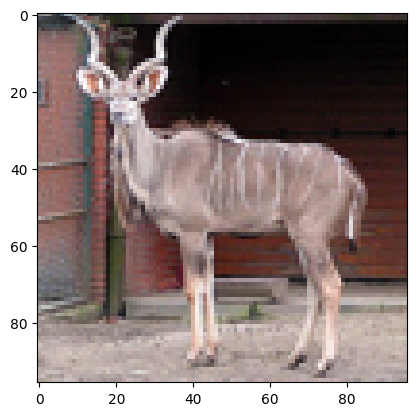

(100000, 96, 96, 3)

In [7]:
plot_image(unlabeled_images[0])
unlabeled_images.shape

In [58]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

# Prétraitement des données
input_shape = (96, 96, 3)
latent_dim = 16
nb_of_unlabeled_images = 10000

# Division des données non labellisées en ensembles d'entraînement et de validation
train_images_unlabeled, val_images_unlabeled = train_test_split(unlabeled_images[:nb_of_unlabeled_images], test_size=0.2, random_state=42)

# Normalisation des images
train_images_unlabeled = train_images_unlabeled / 255.0
val_images_unlabeled = val_images_unlabeled / 255.0

# Construction de l'autoencodeur
input_img = Input(shape=input_shape)

# Encodeur
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
encoded = Dense(latent_dim, activation='relu', name='encoded')(x)
print("encoded.shape", encoded.shape)
##############################################################################################################
# Décodeur
x = Dense(12*12*128, activation='relu')(encoded)
x = tf.reshape(x, shape=(-1, 12, 12, 128))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Modèle de l'autoencodeur
autoencoder = Model(input_img, decoded)

autoencoder.summary()

encoded.shape (None, 16)
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 96, 96, 128)       3584      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 48, 48, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_43 (Conv2D)          (None, 48, 48, 64)        73792     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (None

In [59]:
# Compilation et entraînement de l'autoencodeur
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(train_images_unlabeled, train_images_unlabeled, epochs=10, batch_size=128, validation_data=(val_images_unlabeled, val_images_unlabeled))

Epoch 1/10
63/63 [==============================] - 552s 9s/step - loss: 0.0562 - val_loss: 0.0385
Epoch 2/10
63/63 [==============================] - 568s 9s/step - loss: 0.0353 - val_loss: 0.0323
Epoch 3/10
63/63 [==============================] - 589s 9s/step - loss: 0.0315 - val_loss: 0.0298
Epoch 4/10
63/63 [==============================] - 654s 10s/step - loss: 0.0298 - val_loss: 0.0289
Epoch 5/10
63/63 [==============================] - 685s 11s/step - loss: 0.0289 - val_loss: 0.0279
Epoch 6/10
63/63 [==============================] - 794s 13s/step - loss: 0.0282 - val_loss: 0.0281
Epoch 7/10
63/63 [==============================] - 848s 14s/step - loss: 0.0278 - val_loss: 0.0265
Epoch 8/10
63/63 [==============================] - 841s 13s/step - loss: 0.0267 - val_loss: 0.0276
Epoch 9/10
63/63 [==============================] - 851s 14s/step - loss: 0.0267 - val_loss: 0.0258
Epoch 10/10
63/63 [==============================] - 902s 14s/step - loss: 0.0263 - val_loss: 0.0258


In [33]:
# Compilation et entraînement de l'autoencodeur
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(train_images_unlabeled, train_images_unlabeled, epochs=10, batch_size=64, validation_data=(val_images_unlabeled, val_images_unlabeled))

Epoch 1/10
125/125 [==============================] - 555s 4s/step - loss: 0.0459 - val_loss: 0.0314
Epoch 2/10
125/125 [==============================] - 602s 5s/step - loss: 0.0290 - val_loss: 0.0273
Epoch 3/10
125/125 [==============================] - 596s 5s/step - loss: 0.0267 - val_loss: 0.0244
Epoch 4/10
125/125 [==============================] - 541s 4s/step - loss: 0.0240 - val_loss: 0.0238
Epoch 5/10
125/125 [==============================] - 532s 4s/step - loss: 0.0229 - val_loss: 0.0220
Epoch 6/10
125/125 [==============================] - 772s 6s/step - loss: 0.0224 - val_loss: 0.0221
Epoch 7/10
125/125 [==============================] - 940s 8s/step - loss: 0.0222 - val_loss: 0.0221
Epoch 8/10
125/125 [==============================] - 1077s 9s/step - loss: 0.0219 - val_loss: 0.0212
Epoch 9/10
125/125 [==============================] - 1006s 8s/step - loss: 0.0218 - val_loss: 0.0214
Epoch 10/10
125/125 [==============================] - 1071s 9s/step - loss: 0.0216 - val

In [60]:
# Sauvegarde de l'autoencodeur
autoencoder.save('autoencoder_3.keras')

In [36]:
# Version où on crée un nouveau modèle qui comprend l'encodeur
encoder_input = autoencoder.input
encoder_output = autoencoder.get_layer('encoded').output

# Ajout de la couche Dense de dimension 10 pour la classification
x = Dense(64, activation='relu', name='moins_2')(encoder_output)
x = Dense(32, activation='linear', name='last_dense')(x)
classification_layer = Dense(10, activation='softmax', name='classification')(x)

# Création du modèle complet avec l'encoder et la nouvelle couche de classification
classification_model = Model(inputs=encoder_input, outputs=classification_layer)

# Compilation du modèle
classification_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history_classification_model = classification_model.fit(train_images, 
                                                        train_labels, 
                                                        epochs=3,
                                                        validation_data=(valid_images, valid_labels),
                                                        batch_size = 32,)

Epoch 1/3
100/100 [==============================] - 28s 261ms/step - loss: 4.8529 - accuracy: 0.0988 - val_loss: 2.3049 - val_accuracy: 0.0700
Epoch 2/3
100/100 [==============================] - 28s 276ms/step - loss: 2.3023 - accuracy: 0.1103 - val_loss: 2.3078 - val_accuracy: 0.0700
Epoch 3/3
100/100 [==============================] - 29s 292ms/step - loss: 2.3019 - accuracy: 0.1103 - val_loss: 2.3090 - val_accuracy: 0.0700


In [73]:
# Évaluation des performances sur l'ensemble de test
test_loss_classification_model, test_accuracy_classification_model = classification_model.evaluate(test_images, test_labels)
print('Test Loss:', test_loss_classification_model)
print('Test Accuracy:', test_accuracy_classification_model)


32/32 [==============================] - 2s 67ms/step - loss: 2.3044 - accuracy: 0.0950
Test Loss: 2.304436683654785
Test Accuracy: 0.0949999988079071


In [35]:
from tensorflow import keras

In [16]:
# Version qui va prendre les représentations dans l'espace latent
encoder_input = autoencoder.input
encoder_output = autoencoder.get_layer('encoded').output
encoder = Model(inputs=encoder_input, outputs=encoder_output)

# On va projeter les données dans l'espace latent pour commencer
encoded_train_images = encoder.predict(train_images)
encoded_test_images = encoder.predict(test_images)

# Crée un modèle de classification avec des couches supplémentaires
classifier = keras.Sequential([
    layers.Dense(64, activation="linear"),
    layers.Dense(10, activation="softmax")
])

# Compile et entraîne le classifieur sur les caractéristiques encodées
classifier.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
classifier.fit(encoded_train_images, train_labels, epochs=30, batch_size=32, )  # Utilise les étiquettes d'entraînement appropriées

32/32 [==============================] - 3s 91ms/step
Epoch 1/30
100/100 [==============================] - 1s 2ms/step - loss: 244.4898 - accuracy: 0.1187
Epoch 2/30
100/100 [==============================] - 0s 2ms/step - loss: 78.1746 - accuracy: 0.1950
Epoch 3/30
100/100 [==============================] - 0s 2ms/step - loss: 41.6871 - accuracy: 0.2319
Epoch 4/30
100/100 [==============================] - 0s 2ms/step - loss: 26.0487 - accuracy: 0.2344
Epoch 5/30
100/100 [==============================] - 0s 2ms/step - loss: 18.4821 - accuracy: 0.2406
Epoch 6/30
100/100 [==============================] - 0s 2ms/step - loss: 19.7660 - accuracy: 0.2175
Epoch 7/30
100/100 [==============================] - 0s 2ms/step - loss: 16.9865 - accuracy: 0.2050
Epoch 8/30
100/100 [==============================] - 0s 2ms/step - loss: 14.9063 - accuracy: 0.2344
Epoch 9/30
100/100 [==============================] - 0s 2ms/step - loss: 12.7772 - accuracy: 0.2028
Epoch 10/30
100/100 [===============

In [23]:
train_images_unlabeled[0].shape

(96, 96, 3)

In [61]:
# On prédit les images pour les comparer aux originales
predicted_val_images_unlabeled = autoencoder.predict(val_images_unlabeled)

63/63 [==============================] - 20s 313ms/step


In [ ]:
# Ici qu'on génère l'image reconstruite pour comparaison
indice = 10
for i in range(indice):
    plot_image(predicted_val_images_unlabeled[i])
    # save the image
    plt.imsave(f'image_reconstruite_{i}_latent_16.png', predicted_val_images_unlabeled[i])
    plot_image(val_images_unlabeled[i])
    plt.imsave(f'image_originale_{i}_latent_16.png', val_images_unlabeled[i])

### Méthode 2: Train + predict + train
On va maintenant faire un entrainement en 3 phases. Pour la première étape nous allons entrainer notre modèle baseline sur les données labellisées. Ensuite nous allon utiliser ce modèle pour classer les données non labellisées. Enfin nous allons entrainer de nouveau notre modèle sur le nouvel ensemble de données.

### Training model baseline

In [77]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Dimension de l'espace latent
latent_dim = 16

# Encoder
input_img = Input(shape=(96, 96, 3))
flatten_img = tf.keras.layers.Flatten()(input_img)
encoded = Dense(latent_dim, activation='relu')(flatten_img)

# Decoder
decoded = Dense(96*96*3, activation='sigmoid')(encoded)
reshape_decoded = tf.keras.layers.Reshape((96, 96, 3))(decoded)

# Auto-encoder complet
autoencoder2 = Model(input_img, reshape_decoded)

# Compilation du modèle
autoencoder2.compile(optimizer='adam', loss='mse')

# Afficher le résumé du modèle
autoencoder2.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 flatten_8 (Flatten)         (None, 27648)             0         
                                                                 
 dense_9 (Dense)             (None, 16)                442384    
                                                                 
 dense_10 (Dense)            (None, 27648)             470016    
                                                                 
 reshape_1 (Reshape)         (None, 96, 96, 3)         0         
                                                                 
Total params: 912400 (3.48 MB)
Trainable params: 912400 (3.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
# Compilation et entraînement de l'autoencodeur
autoencoder2.compile(optimizer='adam', loss='mse')
autoencoder2.fit(train_images_unlabeled, train_images_unlabeled, epochs=10, batch_size=128, validation_data=(val_images_unlabeled, val_images_unlabeled))

Epoch 1/10
63/63 [==============================] - 14s 194ms/step - loss: 0.0688 - val_loss: 0.0612
Epoch 2/10
63/63 [==============================] - 5s 83ms/step - loss: 0.0580 - val_loss: 0.0576
Epoch 3/10
63/63 [==============================] - 6s 93ms/step - loss: 0.0565 - val_loss: 0.0571
Epoch 4/10
63/63 [==============================] - 5s 83ms/step - loss: 0.0562 - val_loss: 0.0569
Epoch 5/10
63/63 [==============================] - 5s 87ms/step - loss: 0.0559 - val_loss: 0.0565
Epoch 6/10
63/63 [==============================] - 5s 84ms/step - loss: 0.0555 - val_loss: 0.0565
Epoch 7/10
63/63 [==============================] - 5s 83ms/step - loss: 0.0554 - val_loss: 0.0564
Epoch 8/10
63/63 [==============================] - 6s 102ms/step - loss: 0.0551 - val_loss: 0.0559
Epoch 9/10
63/63 [==============================] - 5s 79ms/step - loss: 0.0548 - val_loss: 0.0557
Epoch 10/10
63/63 [==============================] - 5s 72ms/step - loss: 0.0545 - val_loss: 0.0553


63/63 [==============================] - 1s 7ms/step


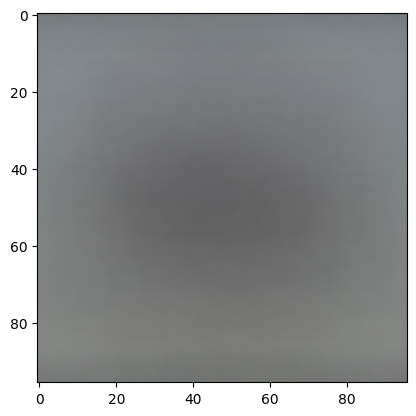

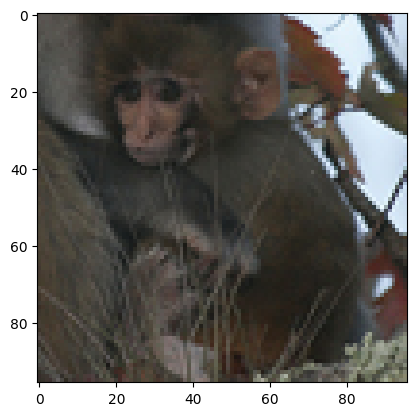

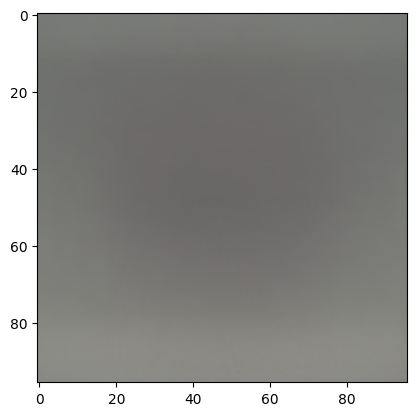

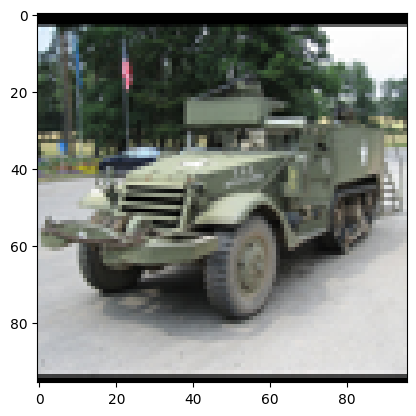

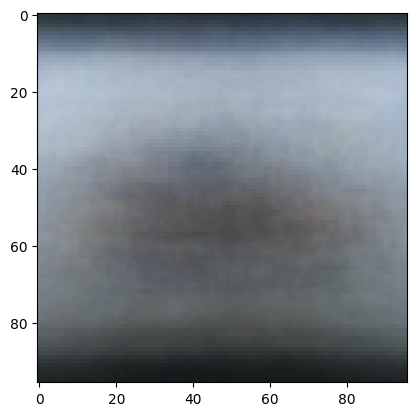

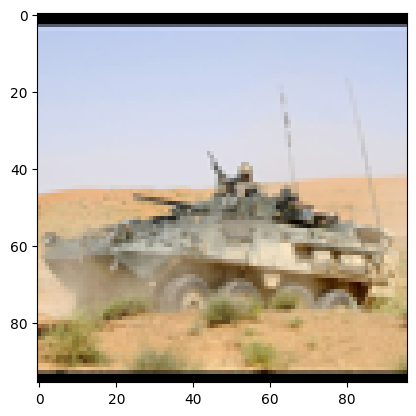

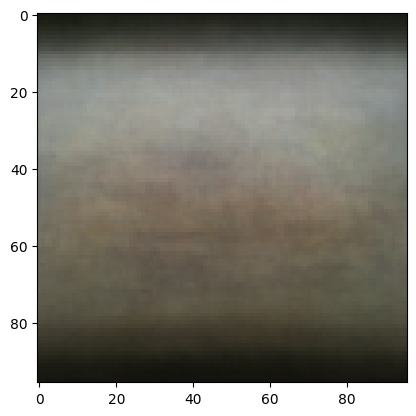

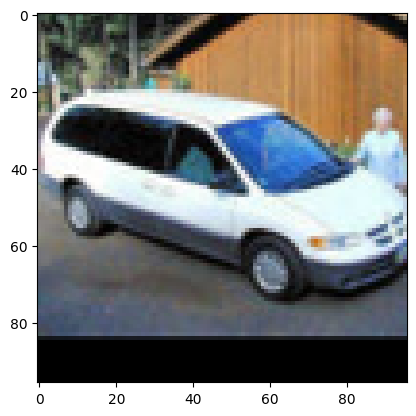

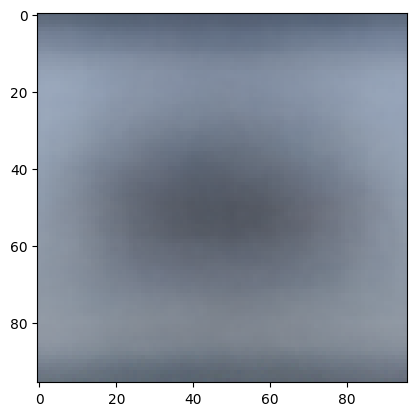

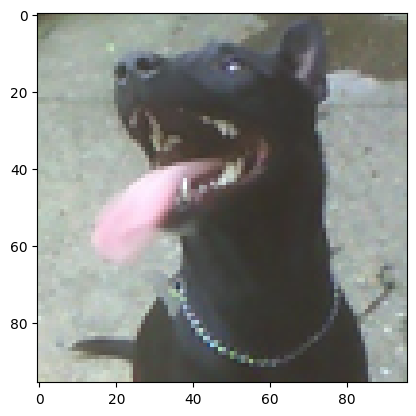

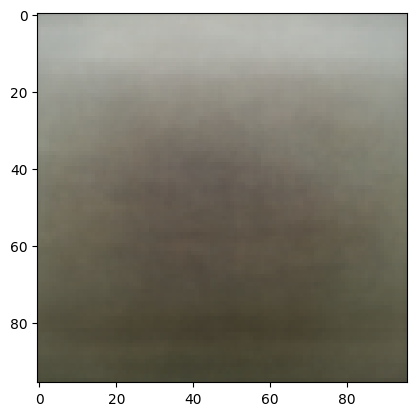

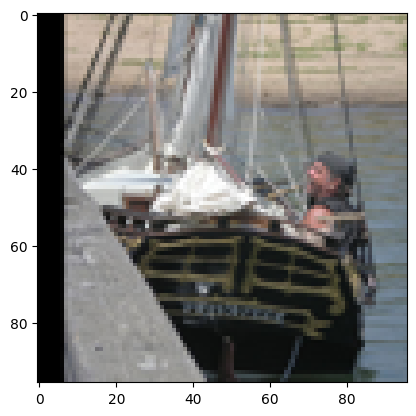

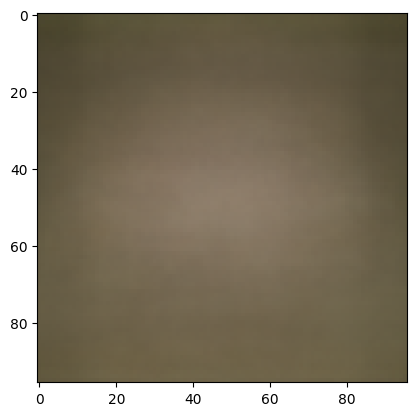

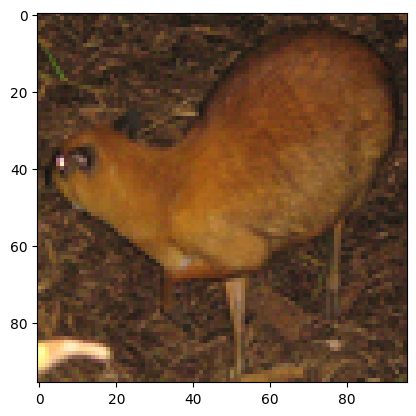

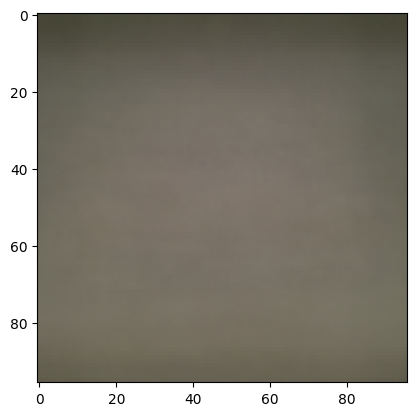

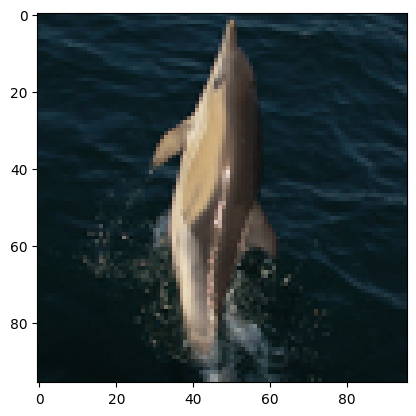

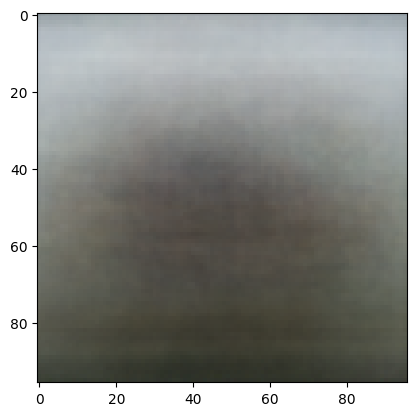

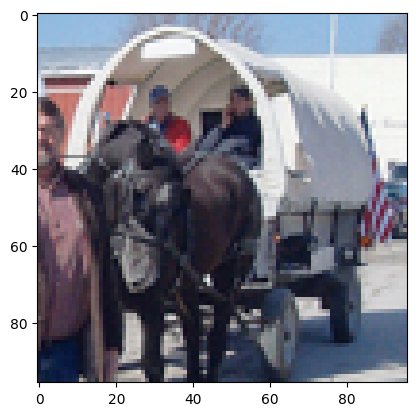

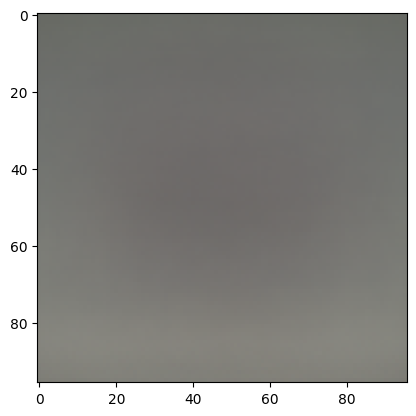

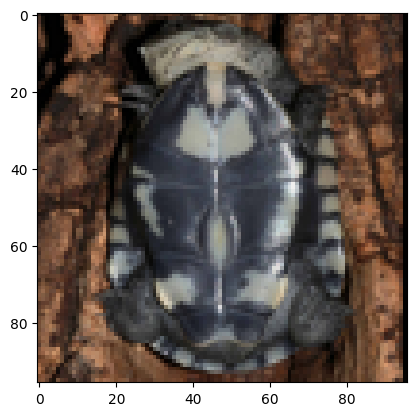

In [79]:
# On prédit les images pour les comparer aux originales
predicted_val_images_unlabeled2 = autoencoder2.predict(val_images_unlabeled)
# Ici qu'on génère l'image reconstruite pour comparaison
indice = 10
for i in range(indice):
    plot_image(predicted_val_images_unlabeled2[i])
    # save the image
    plt.imsave(f'image_reconstruite_{i}_latent_16.png', predicted_val_images_unlabeled2[i])
    plot_image(val_images_unlabeled[i])
    plt.imsave(f'image_originale_{i}_latent_16.png', val_images_unlabeled[i])

### On reprend notre modèle baseline 
Il va servir à prédire les labels sur les données qui n'en ont pas.